In [1]:
import glob
import matplotlib.pyplot as plt
import torchvision
import librosa
import random
import json
import pickle
import numpy as np
import torch
import os
torch.multiprocessing.set_sharing_strategy('file_system')
import tqdm
import gc
import sys
sys.path.append("/home/user/Research/sonifications-paper1517/")
from src.utilities import fourier_analysis
from src.utilities import interpretability_utils
from src.utilities import feature_evolution_helper
import IPython.display as ipd
import soundfile as sf
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (30,40)
import random
import json
import tqdm
import numpy as np

/home/user/miniconda3/envs/asr-env/lib/python3.8/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [2]:
exp_dir = "/media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/"

In [3]:
model, net, deconv, hparams = interpretability_utils.model_helper(exp_dir, True)

Loading /media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/ckpts/epoch=100_tr_loss=1.124386_tr_acc=0.854235.pth


In [4]:
with open("/media/user/nvme/contrastive_experiments/contrastive_select_inputs_evolution.pkl", "rb") as fd:
    selected_inputs = pickle.load(fd)

In [5]:
with open("/media/user/nvme/contrastive_experiments/contrastive_select_maps.pkl", "rb") as fd:
    selected_maps = pickle.load(fd)

In [6]:
val_loader, val_set, lbl_map, inv_lbl_map = interpretability_utils.make_dataloader("/media/user/nvme/datasets/audioset/meta_8000/", hparams.cfg['audio_config'], csv_name="eval.csv")

In [7]:
ckpt_idxs = feature_evolution_helper.get_ckpt_indices(is_contrastive=True)

In [8]:
from tqdm import notebook

In [9]:
ckpt_idxs

[100, 80, 60, 40, 20, 1]

In [10]:
from tqdm import notebook

In [11]:
results = feature_evolution_helper.process_features_over_training(exp_dir, ckpt_idxs, 1, selected_inputs, val_set, inv_lbl_map, is_contrastive=True)

{39: [3228], 2: [1560]}


  0%|          | 0/6 [00:00<?, ?it/s]

Loading /media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/ckpts/epoch=100_tr_loss=1.124386_tr_acc=0.854235.pth
Loading /media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/ckpts/epoch=080_tr_loss=1.166729_tr_acc=0.846442.pth
Loading /media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/ckpts/epoch=060_tr_loss=1.260719_tr_acc=0.829634.pth
Loading /media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/ckpts/epo

In [13]:
results.keys()

dict_keys([100, 80, 60, 40, 20, 1])

In [14]:
results[100]

{39: [{'data_idx': 3318,
   'vis': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
   'gt': 'Civil defense siren;Siren'}],
 2: [{'data_idx': 1601,
   'vis': array([ 0.        ,  0.        ,  0.        , ..., -0.06037735,
          -0.05019003, -0.08424024], dtype=float32),
   'gt': 'Boom;Speech'}]}

In [30]:
def plot_evo_spectrograms(layer_results, layer_idx, ckpt_idxs):
    specs = {}
    for epoch, data in layer_results.items():
        for key, value in data.items():
            # print(key, value, len(value))
            vis = value[0]['vis']
            spec = interpretability_utils.get_spec(vis)
            # print(spec.shape)
            # spec = torch.from_numpy(spec).unsqueeze
            torch_spec = torch.cat([torch.from_numpy(spec).unsqueeze(0)]*3)
            try:
                specs[key].append(torch_spec)
            except KeyError as ex:
                specs[key] = [torch_spec]
    return specs

In [50]:
def tile_spectrograms(specs):
    all_specs = []
    for key, val in specs.items():
        print(key)
        key_specs = []
        for item in val[::-1]:
            # key_specs.append(item)
            all_specs.append(item)
        # key_specs = key_specs[::-1]
        all_specs.extend(key_specs)
    return all_specs

In [34]:
res = plot_evo_spectrograms(results, 1, ckpt_idxs)

In [51]:
all_specs = tile_spectrograms(res)

39
2


In [43]:
from torchvision.utils import make_grid

In [52]:
layergrid = make_grid(all_specs, nrow=6, padding=5, normalize=True)

In [45]:
layergrid.shape

torch.Size([3, 529, 2045])

In [46]:
import matplotlib.pyplot as plt

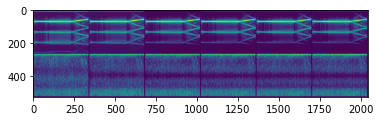

In [53]:
plt.imshow(layergrid[0])

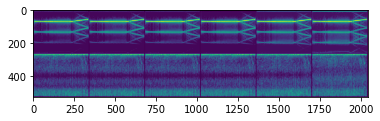

In [47]:
plt.imshow(layergrid[0])

In [10]:
for layer_idx in notebook.tqdm(range(1, 12)):
    results = feature_evolution_helper.process_features_over_training(exp_dir, ckpt_idxs, layer_idx, selected_inputs, val_set, inv_lbl_map, is_contrastive=True)
    feature_evolution_helper.plot_evo_spectrograms(results, layer_idx, ckpt_idxs)

  0%|          | 0/11 [00:00<?, ?it/s]

{14: [1560], 62: [6772], 44: [8119], 3: [6772], 39: [3228], 2: [6772]}


  0%|          | 0/6 [00:00<?, ?it/s]

Loading /media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/ckpts/epoch=100_tr_loss=1.124386_tr_acc=0.854235.pth
Loading /media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/ckpts/epoch=080_tr_loss=1.166729_tr_acc=0.846442.pth
Loading /media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/ckpts/epoch=060_tr_loss=1.260719_tr_acc=0.829634.pth
Loading /media/user/nvme/contrastive_experiments/experiments_contrastive_v5/cnn12_1x_full_tr_8x256_Adam_1e-3_warmupcosine_0.5_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemasking_bgnoise_nolineareval/ckpts/epo

TypeError: plot_evo_spectrograms() missing 1 required positional argument: 'output_dir'